In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import math

In [4]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1.e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# get_custom_objects().update({'dice_coef_loss': Loss(_ReLU)})
def focal_loss(labels, logits, gamma=2.0, alpha=4.0): #[[[]],[[]],[[]],[[]],[[]]]):

    epsilon = 1.e-9
    f_loss_1 = -(alpha * (1-logits)**gamma * labels * K.log(logits + epsilon))
    f_loss_0 = -((logits)**gamma * (1 - labels) * K.log(1 - logits + epsilon))

    f_loss = f_loss_1 + f_loss_0

    # Average over each data point/image in batch
    axis_to_reduce = range(1, K.ndim(f_loss))
    f_loss = K.mean(f_loss, axis=axis_to_reduce)

    return f_loss

def combine_loss(y_true, y_pred):
    return dice_coef_loss(y_true, y_pred) * 0.02 + focal_loss(y_true, y_pred) * 2

In [5]:
custom_objects = {"dice_coef_loss": dice_coef_loss, "focal_loss": focal_loss,
                    "dice_coef": dice_coef, "combine_loss": combine_loss}
with keras.utils.custom_object_scope(custom_objects):
    model = keras.models.load_model(r'model_0014_acc07.h5')

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-16 18:21:30.330129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 18:21:30.330723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
Y_pred = model.predict(img_data_valid)
ans = Y_pred.reshape(100, 192, 320, 4)
val = mask_valid.reshape(100, 192, 320, 4)
# cv2.imshow("res",img_data[6])
# cv2.waitKey(0)
# cv2.destroyAllWindows

for pic in range(34, 40):
  fn, ax = plt.subplots(3, 4)
  for i in range(3):

      # plt.subplot(2,3,i+1)
      result_img = np.clip(ans[pic,:,:,i], 0, 255)
      result_img *= 255
      
      # print(result_img.shape, np.max(result_img), np.min(result_img))
      _, result_img = cv2.threshold(result_img, 200 , 255, cv2.THRESH_BINARY)

      ax[0][i].imshow(result_img)
      ax[1][i].imshow(val[pic,:,:,i])
    # result_img = cv2.resize(result_img, [640,360])
    # cv2.imwrite("output/"+str(i)+".png", result_img)
# plt.imshow()

NameError: name 'img_data_valid' is not defined

In [7]:
from model import segnet
model_test = segnet((288, 512, 3), 4)
model_test.load_weights('segnet_09844_09811.h5')

Build enceder done..
Build decoder done..


In [12]:
def court(img):
    
    h, w = img.shape[:2]
    if np.max(img) == 0:
        return None
    else:
        print(np.max(img))
    
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(cnt)
    arr = np.zeros((h, w), np.uint8)
    box = cv2.approxPolyDP(hull, 3, True)
    
    minimum = box[:,0,:].argmin(axis=0) # x_min, y_min
    maximum = box[:,0,:].argmax(axis=0) # x_max, y_max
    
    left = box[minimum[0]][0]
    right = box[maximum[0]][0]
    top = box[minimum[1]][0]
    bottom = box[maximum[1]][0]

    if left[0] == 0:
        left = []
    if right[0] == w-1:
        right = []
    if top[0] == 0 or top[0] == w-1:
        top = []
    if bottom[0] == 0 or bottom[0] == w-1:
        bottom = []

    ans = [top, right, bottom, left]
    return ans
    
def transform(pts1, pts2, mask, type):
    # pts1 : to
    # pts2 : from
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    M = cv2.getPerspectiveTransform(pts2,pts1)
    if type == 1:
        dst = cv2.warpPerspective(mask,M,(1224, 690))
    else:
        dst = cv2.warpPerspective(mask,M,(512, 288))

    return dst, M
    

In [14]:
def count_dot(a):
    count = 0
    for i in a:
        if len(i) != 0:
            count += 1

    return count

In [290]:
mask = cv2.imread("prepare_data/court.png", cv2.COLOR_BGR2RGB)
kernel = np.ones((3,3), np.uint8)
mask = cv2.dilate(mask, kernel, 5)
cv2.imwrite("mask_to_display.png", mask)

True

In [10]:
mask_valid = np.load("mask_valid.npy")
image_data_valid = np.load("img_data_valid.npy")

1/1 [==============================] - 0s 168ms/step
255
4 0 0
[[ 15.21832498 241.54778096]
 [249.21832498 241.54778096]
 [249.21832498 437.54778096]
 [ 15.21832498 437.54778096]]
[array([210, 142], dtype=int32), array([351, 158], dtype=int32), array([287, 187], dtype=int32), array([137, 160], dtype=int32)]
[[-1.49125962e+00 -6.20772343e+00  1.17941724e+03]
 [ 8.50765288e-01 -1.20524826e+01  1.29083640e+03]
 [-6.49288721e-04 -1.31361757e-02  1.00000000e+00]]
[[ 100.31103778]
 [-261.0977152 ]
 [  -0.92007529]]
1.648991710235707


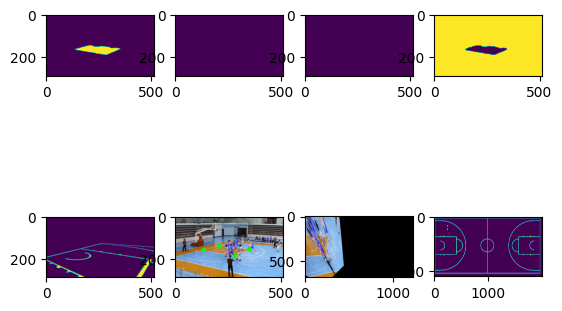

In [15]:
path = "test_images/"
kernel = np.ones((3,3), np.uint8)
count = 0
mask = cv2.imread("unused_img/200_255.png", cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, (1996, 1096))
ob = np.load("prepare_data/transform_base_back.npy")
video = "result/guest_setplay.mp4"


for f in os.listdir(path):
    count += 1
    if count % 5 != 0 :
        continue

    fn, ax = plt.subplots(2, 4)
    image = cv2.imread( "test_images/Image647.jpg")#os.path.join(path, f), cv2.COLOR_BGR2RGB)
    # ax[count][0].imshow(img)
    
    
    image = cv2.resize(image, (512, 288))
    img = np.array(image, np.float32)
    img /= 255 
    img = [img]
    ans = model_test.predict(np.array(img))
    ans = ans.reshape((1, 288, 512, 4))
    handle_img = ans[0]
    handle_img = np.where(handle_img>0.5, 255, 0)
    handle_img = np.array(handle_img, np.uint8)
    
    
    for i in range(4):
        # cv2.imwrite("result" + str(i) + ".png", handle_img[:,:,i])
        handle_img[:,:,i] = cv2.dilate(handle_img[:,:, i], kernel, iterations = 3)
        handle_img[:,:,i] = cv2.erode(handle_img[:,:, i], kernel, iterations = 3)
        ax[0][i].imshow(handle_img[:,:, i])

    # count += 1
    # if count > 2:
    #     break
    
    left_dot = 0
    right_dot = 0
    center_dot = 0
    pts1=[]
    pts2=[]

    left = court(handle_img[:,:,0])
    
    right= court(handle_img[:,:,1])
    
    center = court(handle_img[:,:,2])
    
    # print(left, right , center)
    
    if left is not None:
        left_dot = count_dot(left)
    if right is not None:
        right_dot = count_dot(right)
    if center is not None:
        center_dot = count_dot(center)
    
    print(left_dot, right_dot, center_dot)

    if left_dot == 4:
        pts1 = ob[0]
        pts2 = left
    elif right_dot == 4:
        pts1 = ob[2]
        pts2 = right
    elif center_dot == 4:
        pts1 = ob[1]
        pts2 = center
    elif right_dot is None:
        pts1 = ob[3]
        pts2 = [center[0], center[2], left[1], left[2]]
    elif left_dot is None:
        pts1 = ob[4]
        pts2 = [right[2], right[3], center[0], center[2]]

    
    print(pts1)
    print(pts2)
    tf_image, T1 = transform(pts1, pts2, image, 1)
    tfback_image, T2 = transform(pts2, pts1, mask, 2)
    print(T1)
    aaa = np.array([[145], [139],[1]])
    print(T1.dot(aaa))
    # pts1 : to
    # pts2 : from
    w = math.dist(pts1[0], pts1[1]) / math.dist(pts2[0], pts2[1])
    print(w)
    for ii in pts2:
        cv2.circle(image, ii, 5, (0, 255, 0), 10)
    for jj in pts1:
        m = mask.copy()
        jj = np.array(jj,np.uint8 )
        cv2.circle(mask, jj, 5, (255, 0, 0), 10)
    ax[1][0].imshow(tfback_image)
    ax[1][1].imshow(image)
    ax[1][2].imshow(tf_image)
    ax[1][3].imshow(mask)
    plt.show()

    # count += 1
    # if count > 100:
    break



